#Multi-objective Optimization Test Case - Kursawe Function
In this is example we will be solving the [Kursawe function](https://drive.google.com/file/d/1yiCQysLgRxc-MdeCbOTuMGkl3hadgS4f/view?usp=sharing) using NSGA 3. Kursawe is a popular test function used to test different multi-objective optimizations 

This is what the solution should look like ![Kursawe](https://upload.wikimedia.org/wikipedia/commons/thumb/5/53/Kursawe_function.pdf/page1-796px-Kursawe_function.pdf.jpg)


###Step 1: Cloning the Project (House keeping)
Lets clone the test project in Glennopt. We will need the test folder located in `GlennOPT/test/kur/serial`

In [7]:
# Clone the source code for GlennOPT
!git clone https://github.com/nasa/GlennOPT.git
# Little Housekeeping
!cp -r GlennOPT/test/KUR/serial/Evaluation .    # Copy the folder we need 
!rm GlennOPT/ -r        # Deletes GlennOPT source code. We don't need this anymore

Cloning into 'GlennOPT'...
remote: Enumerating objects: 626, done.
remote: Counting objects: 100% (626/626), done.
remote: Compressing objects: 100% (397/397), done.
remote: Total 626 (delta 347), reused 449 (delta 183), pack-reused 0
Receiving objects: 100% (626/626), 529.51 KiB | 4.38 MiB/s, done.
Resolving deltas: 100% (347/347), done.
rm: cannot remove 'sample_data': No such file or directory


In [ ]:
# Install GlennOPT 
!python --version
!pip install glennopt
# Restart the runtime
import os
os.kill(os.getpid(), 9)

Python 3.6.9
     |████████████████████████████████| 11.6MB 350kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


#Folder Structure and Evaluation Script

###Initial folder structure
```
Evaluation
| - evaluate.py     (Gets copied to each individual directory)
multi-objective_example.ipynb
machinefile.txt (Optional, add this if you want to breakdown hosts per evaluation)
```

###After optimization
```
Calculation
| - DOE
| -- IND000
| ----- input.txt   (Generated by optimizer)
| ----- evaluate.py (Executes the cfd and reads results)
| ----- output.txt  (Generated by evaluate.py)
| -- ...
| -- IND128
| - POP000
| -- IND000
| -- ...
| -- IND039
Evaluation
| - evaluate.py     (Gets copied to each individual directory)
multi-objective_example.ipynb
machinefile.txt (Optional, add this if you want to break down hosts per evaluation)
```
Note: Glennopt constructs the calculation folder automatically. Each population is saved as DOE or as POPXXX. This is done so that when you are running a Computational Fluid Simulation or any kind of optimization where crashes could occur, you can investigate why the simulation crashed.

Also if there are any additional post processing that needs to be done, by saving the evaluations this way, it is also possible to re-process the files differently and restart the optimization. **Restarts** will be shown in a later section.


##Evaluation Script
You may have noticed that when in earler codes the github folder is cloned and part of it was copied and the rest of it was deleted. This is done to import the evaluation script found in Evaluation/evaluate.py

The purpose of this script is to call the Kursawe function (kur.py) to perform a single execution. The inputs will be read from an input.dat file and output to output.txt. See `read_input` and `print_output` functions

---
```
# evaluation.py
def read_input(input_filename):
    x = []
    with open(input_filename, "r") as f: 
        for line in f:
            split_val = line.split('=')
            if len(split_val)==2: # x1 = 2 # Grab the 2
                x.append(float(split_val[1]))
    return x
 
def print_output(y):
    with open("output.txt", "w") as f:        
        f.write('objective1 = {0:.6f}\n'.format(y[0])) # Output should contain [Name of the Objective/Parameter] = [value] This is read by the optimizer 
        f.write('objective2 = {0:.6f}\n'.format(y[1]))
        f.write('p1 = {0:.6f}\n'.format(y[2]))
        f.write('p2 = {0:.6f}\n'.format(y[3]))
        f.write('p3 = {0:.6f}\n'.format(y[4]))
        # f.write('Objective2 = {0:.6f}\n'.format(y))
 
if __name__ == '__main__':
    x = read_input("input.dat")
    # Call Rosebrock test function 
    import kur as kur
    y = kur.KUR(x[0],x[1],x[2])
    print_output(y)
```
## Kursawe Function
This is the kursawe function copied from wikipedia
```
# kur.py
import math

def KUR(x1,x2,x3):
    '''
        Kursawe Function
        mutiple output
    '''
    f1 = (-10*math.exp(-0.2*math.sqrt(x1*x1+x2*x2))) + (-10*math.exp(-0.2*math.sqrt(x2*x2+x3*x3)))

    f2 = (math.pow(abs(x1),0.8)+5*math.sin(x1*x1*x1))+(math.pow(abs(x2),0.8)+5*math.sin(x2*x2*x2))+(math.pow(abs(x3),0.8)+5*math.sin(x3*x3*x3))
    # Performance Parameter
    p1 = x1 + x2 + x3
    p2 = x1*x2*x3
    p3 = x1 - x2 - x3
    return f1,f2,p1,p2,p3
```




#Optimization

Import relevant libraries

In [1]:
from glennopt.helpers import Parameter, parallel_settings
from glennopt.nsga3 import de_mutation_type, mutation_parameters, NSGA3
import numpy as np
import os

**Evaluation Parameters**: are required. This is the vector of variables that goes into your objective function.

**Objectives**: number of objectives to solve for

**Performance Parameters**: this is not required but I set this up for reference

In [3]:
# Define the Evaluation Parameters
eval_parameters = []
eval_parameters.append(Parameter(name="x1",min_value=-5,max_value=5))
eval_parameters.append(Parameter(name="x2",min_value=-5,max_value=5))
eval_parameters.append(Parameter(name="x3",min_value=-5,max_value=5))

# Define the number of objectives
objectives = list()
objectives.append(Parameter(name='objective1'))
objectives.append(Parameter(name='objective2'))

# Define any performance parameters you want to keep track of (tracking only)
perf_parameters = list()
perf_parameters.append(Parameter(name='p1'))
perf_parameters.append(Parameter(name='p2'))
perf_parameters.append(Parameter(name='p3'))

In [4]:
# Set up the optimizer
current_dir = os.getcwd()
pop_size = 48
ns = NSGA3(eval_script = "Evaluation/evaluation.py", eval_folder="Evaluation",pop_size=pop_size,optimization_folder=current_dir)
ns.add_eval_parameters(eval_params = eval_parameters)
ns.add_performance_parameters(perf_parameters)
ns.add_objectives(objectives=objectives)

In [5]:
# Set the mutation parameters
ns.mutation_params.mutation_type = de_mutation_type.de_rand_1_bin   # Choice of de_best_1_bin (single objective) or de_rand_1_bin (multi-objective)
ns.mutation_params.F = 0.8
ns.mutation_params.C = 0.7

**If you want other mutaton strategies or crossover strategies just add an issue to the github and provide as many references and examples as possible. We will try to incorporate them. **

Enable Parallel Execution (OPTIONAL) 

In [6]:
# Parallel Settings (You don't need to run this block if you only want serial execution)
ns.parallel_settings.concurrent_executions = 8    # Change to 1 for serial
ns.parallel_settings.cores_per_execution: 1    
ns.parallel_settings.execution_timeout = 0.2      # minutes

##Run the Design of Experiments
Design of experiments is used to sample the evaluation space. Say you have 5 variables and f(x[1-5]) = y[1,2] and each x1 through x5 have min and max bounds. The design of experiments is used to evaluate different combinations of x1 to x5 which are used as the starting population (pop_start=-1) 

In [7]:
# Run the Design of Experiments
ns.start_doe(doe_size=128)                                    # This generates individuals that have evaluation parameters randomly distributed between the bounds 

In [8]:
# Execute the Optimization
ns.optimize_from_population(pop_start=-1,n_generations=25)    # Start from the DOE and iterate from pop 0 to 24

###Restarting the Simulation from a previous restart file


In [9]:
ns.optimize_from_population(pop_start=24,n_generations=25)    # Start from the DOE and iterate from pop 25 to 50

##Generating a restart file
Just in case you accidentally deleted it

In [ ]:
!rm restart_file.csv
ns.create_restart() # Appends/creates a new restart file

##Plotting the Pareto Front





You can make the plots using the glennopt or you can create animated plots of the pareto front

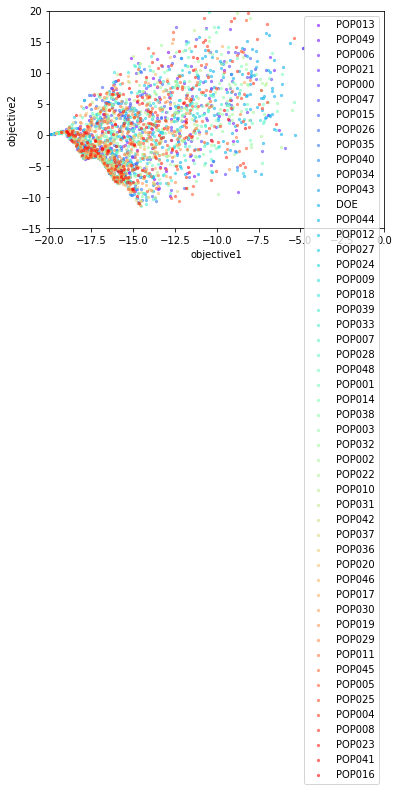

In [20]:
ns.read_calculation_folder()
ns.plot_2D('objective1','objective2',[-20,0],[-15,20])

###Animated Plot
This is an example of an animated plot. It may take a while to run depending on the number of frames and the interval

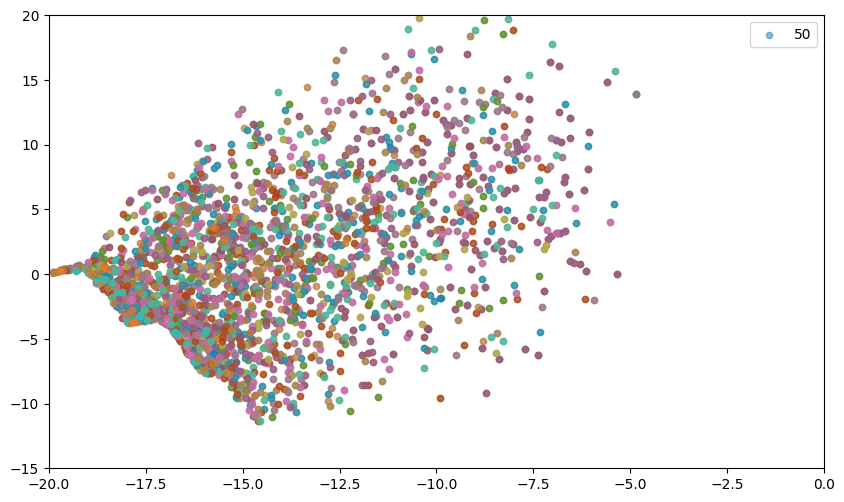

In [118]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import animation, rc
from IPython.display import HTML

num_frames = 150

xlim = [-20,0]
ylim = [-15,20]
obj1_name = 'objective1'
obj2_name = 'objective2'

ns.read_calculation_folder()

fig,ax = plt.subplots(figsize=(10,6), dpi=80, facecolor='w', edgecolor='k')

keys = list(ns.pandas_cache.keys())
keys.sort()
nPop = len(list(ns.pandas_cache.keys()))
divisor = num_frames/nPop
def init():  
  data = get_data(0)
  pop_scatter = ax.scatter(data[:,0],data[:,1],s=20,alpha=0.5)
  ax.set_xlim(xlim[0],xlim[1])
  ax.set_ylim(ylim[0],ylim[1])  
  ax.set_xlabel(obj1_name)
  ax.set_ylabel(obj2_name)
  #pop_scatter.set_array(np.array([]))
  return pop_scatter,

def get_data(pop):  
  key = keys[pop]
  obj_data = list()
  for index, row in ns.pandas_cache[key].iterrows():
    obj_data.append([row[obj1_name],row[obj2_name]])
  return np.array(obj_data)

def animate(pop):
  pop = int(pop/divisor)
  data = get_data(pop)
  pop_scatter = ax.scatter(data[:,0],data[:,1],s=20,alpha=0.5)  
  ax.legend([str(pop)])
  return pop_scatter,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                                frames=num_frames, interval=10, blit=True)
HTML(anim.to_html5_video())   

#Getting the best designs (To be added in a later commit)


Getting the best objective value vs population. This is useful to see if the objective is changing as population increases

In [5]:
from glennopt.base_classes import Individual
# Single Objective
objectives = ns.get_best() # Gets the best objective value vs populaton 
# this data is returned as [[]] of individuals

# Multi-objective          
best_fronts = ns.get_best() # Gets the best front vs population                                      
# this data is returned as [[]] of individuals

NameError: ignored

Getting the best design at each population. 

In [ ]:
objectives = ns.get_pop_best() # Gets the best objective value vs populaton 
# this data is returned as [[]] of individuals

best_fronts = ns.get_pop_best() # Gets the best front vs population                                      
# this data is returned as [[]] of individuals